### Preprocessing Pipeline
1. Create a BIDSDataGrabber Node to read data files
2. Create a IdentityInterface Node to iterate over multiple Subjects
3. Create following Nodes for preprocessing: (Based on [Nan-kuei Chen's resting state analysis pipeline:](https://wiki.biac.duke.edu/biac:analysis:resting_pipeline)
    - [-] convert data to nii in LAS orientation (Skip if NYU is already in [LAS Orientation](http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm))
    - [x] Exclude 4 volumes from the functional scan 
    - [x] slice time correction
    - [x] motion correction, {[then regress out motion parameter] - This will be done later}
    - [x] Skull stripping and mask generation using mean of functional scan got using mcflirt
    - [x] Apply mask to Functional image
    - [] Co-Registration with Anatomical Image
    - [] normalize data
    - [] regress out WM/CSF
    - [] bandpass filter
    
4. Embed them into a workflow
5. Do the Preprocessing of 3 subjects

In [446]:
from bids.grabbids import BIDSLayout
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)

In [447]:
number_of_subjects = 3 # Number of subjects you wish to preprocess

In [448]:
layout = BIDSLayout("/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/")

Checking the Data directory Structure

In [449]:
!tree /home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/

/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/
├── participants.tsv
├── sub-0050952
│   ├── anat
│   │   └── sub-0050952_T1w.nii.gz
│   └── func
│       └── sub-0050952_task-rest_run-1_bold.nii.gz
├── sub-0050953
│   ├── anat
│   │   └── sub-0050953_T1w.nii.gz
│   └── func
│       └── sub-0050953_task-rest_run-1_bold.nii.gz
├── sub-0050954
│   ├── anat
│   │   ├── mask_50954_mask.nii.gz
│   │   ├── mask_50954.nii.gz
│   │   └── sub-0050954_T1w.nii.gz
│   └── func
│       └── sub-0050954_task-rest_run-1_bold.nii.gz
├── sub-0050955
│   ├── anat
│   │   └── sub-0050955_T1w.nii.gz
│   └── func
│       └── sub-0050955_task-rest_run-1_bold.nii.gz
├── sub-0050956
│   ├── anat
│   │   └── sub-0050956_T1w.nii.gz
│   └── func
│       └── sub-0050956_task-rest_run-1_bold.nii.gz
├── sub-0050957
│   ├── anat
│   │   └── sub-0050957_T1w.nii.gz
│   └── func
│       └── sub-0050957_task-rest_run-1_bold.nii.gz
├── sub-0050958
│   ├── anat
│   │   └── sub-0050958_T1w.nii.gz
│   └── func
│       └── s

In [450]:
layout.get_subjects(); # working!Gives us list of all the subjects

To get the metadata associated with a subject. [Takes as argumment the filename of subject ]

In [451]:
metadata = layout.get_metadata(path='/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz')

Let's extract the Repetition Time (of fMRI) of the subject whose metadata was extracted above

In [452]:
TR  = metadata['RepetitionTime']
metadata; # just add or remove the semicolon to supress or see the output

Lets look at a better way to extract the TR of an experiment of fMRI.  
In BIDS format there is one json file associated with the data set that contains the details of the data acquisition. Here we have -> ```task-rest_bold.json```. Let's extract the TR from this file.  
Similarly there is a json file associated with the anatomical scan as well. Here - ```T1w.json```

In [453]:
import json
with open('../data/ABIDE-BIDS/NYU/task-rest_bold.json', 'rt') as fp:
    task_info = json.load(fp)
#TR = task_info['RepetitionTime']
task_info;
# 'rt' means that you want to open the file in read mode and text mode(not sure what text mode is) 
# Also -> with open() as ... is just a fancy way of reading file that makes sure that the file object
# is destroyed automatically

Now you can extract the TR

In [454]:
TR = task_info['RepetitionTime']

Create our own custom function - BIDSDataGrabber using a Function Interface.

In [455]:
def get_nifti_filenames(subject_id,data_dir):
#     Remember that all the necesary imports need to be INSIDE the function for the Function Interface to work!
    from bids.grabbids import BIDSLayout
    
    layout = BIDSLayout(data_dir)
    
    anat_file_path = [f.filename for f in layout.get(subject=subject_id, type='T1w', extensions=['nii', 'nii.gz'])]
    func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])]
    
    return anat_file_path[0],func_file_path[0]

# Refer to Supplementary material section One for info on arguments for layout.get()

Wrap it inside a Node

In [456]:
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.utility import IdentityInterface, Function

In [457]:
BIDSDataGrabber = Node(Function(function=get_nifti_filenames, input_names=['subject_id','data_dir'],
                                output_names=['anat_file_path','func_file_path']), name='BIDSDataGrabber')


In [458]:
#To test the function wrapped in the node

# BIDSDataGrabber.inputs.data_dir = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/'
# BIDSDataGrabber.inputs.subject_id = '0050954'
# res = BIDSDataGrabber.run()

# res.outputs


### Skipping 4 starting scans
Extract ROI for skipping first 4 scans of the functional data 
> **Arguments:**  
t_min: (corresponds to time dimension) Denotes the starting time of the inclusion  
t_size: Denotes the number of scans to include



In [459]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

### Slice time correction
Created a Node that does slice time correction
> **Arguments**:  
index_dir=False -> Slices were taken bottom to top i.e. in ascending order  
interleaved=True means odd slices were acquired first and then even slices [or vice versa(Not sure)] 

In [460]:
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

In [461]:
# To test Slicetimer
# slicetimer.inputs.in_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
# res = slicetimer.run()
# res.outputs

### Motion Correction
Motion correction is done using fsl's mcflirt. It alligns all the volumes of a functional scan to each other

In [462]:
# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

In [463]:
# To test mcflirt
# mcflirt.inputs.in_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
# res_mcflirt = mcflirt.run()
# res_mcflirt.outputs

### Skull striping
I used fsl's BET

In [464]:
from nipype.interfaces.fsl import BET #,ExtractROI can be imported to ignore some brain volumes

In [465]:
skullStrip = Node(BET(mask=True),name='skullStrip') 

*Note*: Do not include special characters in ```name``` field above coz then  wf.writegraph will cause issues

In [466]:
# BET.help(); # Useful to see what are the parameters taken by BET

### Apply Mask to functional data
Mean file of the motion corrected functional scan is sent to skullStrip to get just the brain and the mask_image. Mask_image is just a binary file (containing 1 where brain is present and 0 where it isn't).    
After getting the mask_image form skullStrip, apply that mask to aligned functional image to extract its brain and remove the skull

In [467]:
# Function
def applyMask_func(brain_file, mask_file):
    import numpy as np
    import nibabel as nib
    import os

    # convert from unicode to string : u'/tmp/tmp8daO2Q/..' -> '/tmp/tmp8daO2Q/..' i.e. removes the prefix 'u'
    mask_file = str(mask_file)

    brain_data = nib.load(brain_file)
    mask_data = nib.load(mask_file)

    brain = brain_data.get_data()
    mask = mask_data.get_data()

    # applying mask by multiplying elementwise to the binary mask
    for t in range(brain.shape[-1]):
        brain[:,:,:,t] = np.multiply(brain[:,:,:,t],mask)

    # Saving the brain file

    func_brain_file_path = mask_file + '_func_brain.nii.gz'

    brain_with_header = nib.Nifti1Image(brain, affine=brain_data.affine,header = brain_data.header)
    nib.save(brain_with_header,func_brain_file_path)
    
    return func_brain_file_path



Wrap the above function inside a Node

In [468]:
applyMask = Node(Function(function=applyMask_func, input_names=['brain_file','mask_file'],
                                output_names=['func_brain_file_path']), name='applyMask')

Create an IdentityInterface node to Distribute the subjects 

Create a list of subjects

In [469]:
number_of_subjects = 1

In [470]:
subject_list = (layout.get_subjects())[0:number_of_subjects]

Create an IdentityInterface Node that helps us to iterate over all the subjects. In this type of node the inputs = outputs that's why its called an identity node. It has an aditional feature that it can iterate over the values a single field can take. In our case we tell it to iterate over field '`subject_id`' and take values given by `subject_list`

In [471]:
from nipype import IdentityInterface
infosource = Node(IdentityInterface(fields=['subject_id','data_dir']),
                  name="infosource")
infosource.inputs.data_dir = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/'
infosource.iterables = [('subject_id', subject_list)]
# Note: Field 'data_dir' stays constant while the field'subject_id' takes on various values 
#       as there are multiple subjects

In [472]:
infosource.outputs # Checking the outputs of the above created node


data_dir = <undefined>
subject_id = <undefined>

In [473]:
# Create the workflow
# Refer to Supplementary material's Section Two for more on workspaces

wf = Workflow(name="preprocessPipeline")
wf.base_dir = "/home/jovyan/work/preprocess/result" # Dir where all the outputs will be stored(inside BETFlow folder).

wf.connect([(infosource, BIDSDataGrabber, [('data_dir','data_dir'), ('subject_id', 'subject_id'),]),
                  (BIDSDataGrabber, extract, [('func_file_path','in_file')]),
                  (extract,slicetimer,[('roi_file','in_file')]),
                  (slicetimer,mcflirt,[('slice_time_corrected_file','in_file')]),
                  (mcflirt, skullStrip, [('mean_img', 'in_file')]),
                  (mcflirt,applyMask,[('out_file','brain_file')]),
                  (skullStrip, applyMask, [('out_file', 'mask_file')]), 
                  ])
# Run it in parallel (one core for each smoothing kernel)
wf.run('MultiProc', plugin_args={'n_procs': 8})

170925-00:21:32,157 workflow INFO:
	 Workflow preprocessPipeline settings: ['check', 'execution', 'logging']
170925-00:21:32,174 workflow INFO:
	 Running in parallel.
170925-00:21:32,178 workflow INFO:
	 Executing: BIDSDataGrabber.a0 ID: 0
170925-00:21:32,183 workflow INFO:
	 Executing node BIDSDataGrabber.a0 in dir: /home/jovyan/work/preprocess/result/preprocessPipeline/_subject_id_0050952/BIDSDataGrabber
170925-00:21:32,294 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.a0 jobid: 0
170925-00:21:32,298 workflow INFO:
	 Executing: extract.a0 ID: 1
170925-00:21:32,311 workflow INFO:
	 Executing node extract.a0 in dir: /home/jovyan/work/preprocess/result/preprocessPipeline/_subject_id_0050952/extract
170925-00:21:32,331 workflow INFO:
	 Running: fslroi /home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050952/func/sub-0050952_task-rest_run-1_bold.nii.gz /home/jovyan/work/preprocess/result/preprocessPipeline/_subject_id_0050952/extract/sub-0050952_task-rest_run-1_bold_roi.nii

### Summary:

170925-00:22:46,807 workflow INFO:
	 Creating detailed dot file: /home/jovyan/work/preprocess/result/preprocessPipeline/graph_detailed.dot
170925-00:22:47,438 workflow INFO:
	 Creating dot file: /home/jovyan/work/preprocess/result/preprocessPipeline/graph.dot


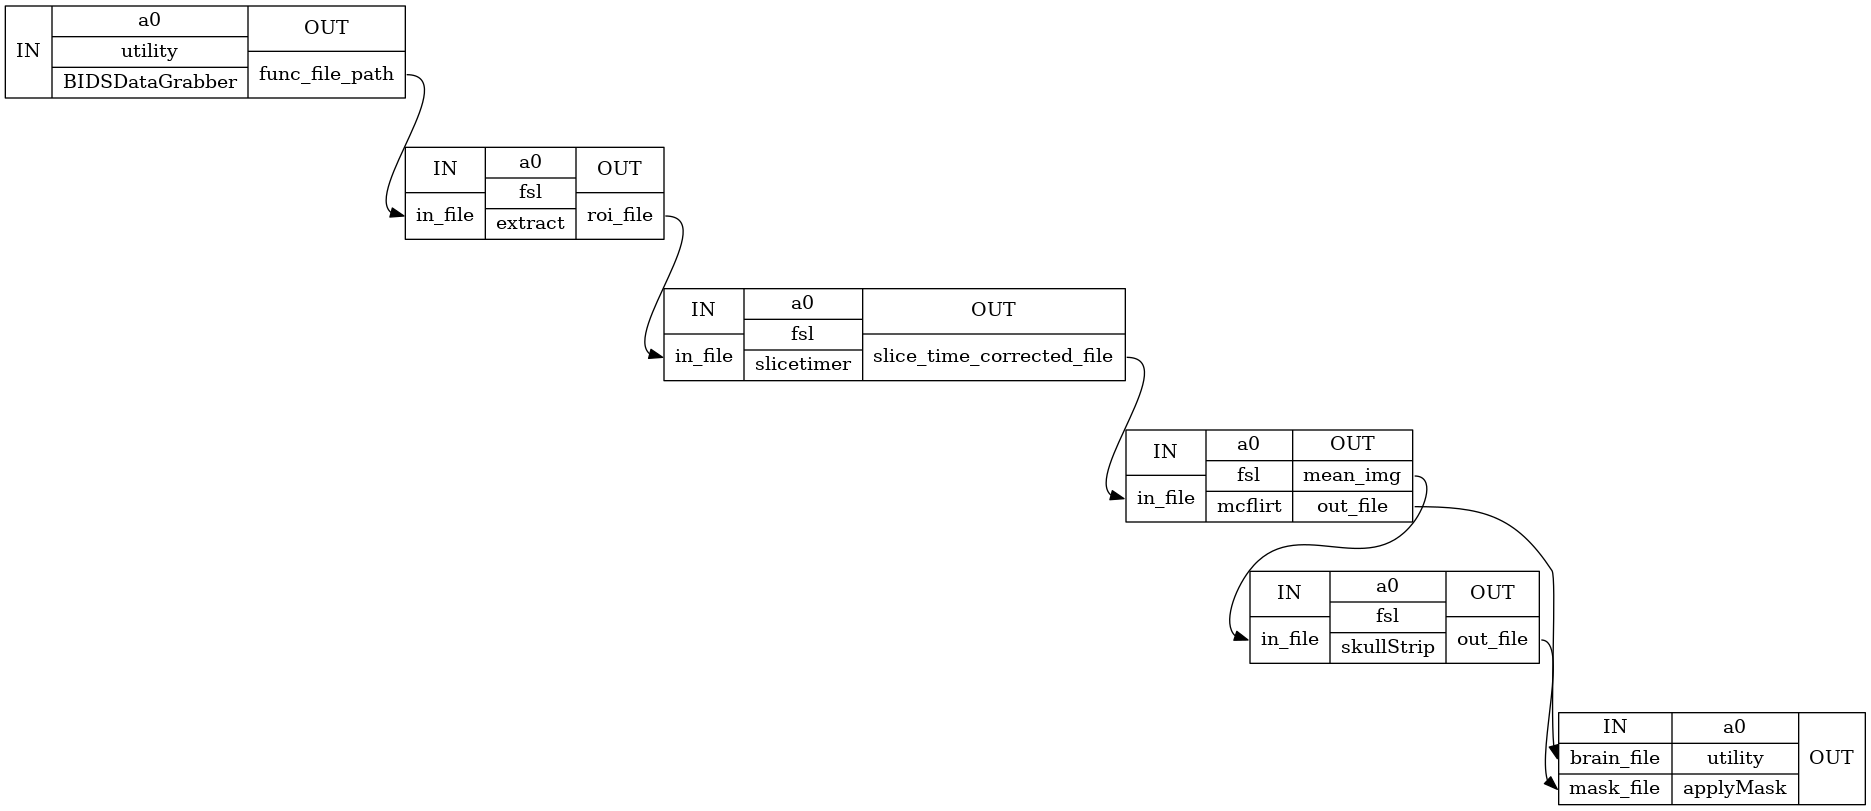

In [474]:
# Visualize the detailed graph
from IPython.display import Image
wf.write_graph(graph2use='exec', format='png', simple_form=True)

Image(filename='/home/jovyan/work/preprocess/result/preprocessPipeline/graph_detailed.dot.png')


```
wf.connect([(infosource, BIDSDataGrabber, [('data_dir','data_dir'), ('subject_id', 'subject_id'),]),
                  (BIDSDataGrabber, extract, [('func_file_path','in_file')]),
                  (extract,slicetimer,[('roi_file','in_file')]),
                  (slicetimer,mcflirt,[('slice_time_corrected_file','in_file')]),
                  (mcflirt, skullStrip, [('mean_img', 'in_file')]),
                  (mcflirt,applyMask,[('out_file','brain_file')]),
                  (skullStrip, applyMask, [('out_file', 'mask_file')]), 
                  ])
```

In the above created workflow the `infosource` node iterates over the `subject_id`, it creates a Node and for each Subject ID it sends `data_dir` (path where the data resides) and the subject specific `subject_id` to `BIDSDataGrabber` Node.

`BIDSDataGrabber` Node accepts the above 2 parameters, calls the function `get_nifti_filenames(subject_id,data_dir)`which returns the path of the anatomical and BOLD files of the subject with given subject_id and hence the Node produces output that I call `func_file_path` and `anat_file_path`. I have used only `func_file_path`right now.

The file path denoted by '``func_file_path``' is then fed as input to `extract` that removes 4 initial brain volumes of the functional scan.

Its output is called - `slice_time_corrected_file` which is fed to `mcflirt` node to correct the movion between volumes of an individual subject. This is called **Motion Correction**.

In next step the mean_image from `mcflirt` is sent to `skullStrip` to get the mask.

The mask got above is then applied to the functional volume to get rif of skull.



The final results are stored in the directory : `/home/jovyan/work/preprocess/result/BETFlow`. Every node has its own folder where its results are stored.




## Utility Functions

In [475]:
# To load and save a brain image to a convenient location so that I can view it in fslview
import nibabel as nib

def load_and_save(filepath, name):
    brain_data = nib.load(filepath)
#     brain_tensor = brain_data.get_data()

    print "Saving the brain file with name: ", name
    # brain_MC_with_header = nib.Nifti1Image(fullbrain_atlas, affine=bn.affine,header = bn.header)
    nib.save(brain_data, name)

In [476]:
# load_and_save(str(res.outputs.slice_time_corrected_file), 'slicetimecorrectedfile_50954)

In [477]:
# MCFLIRT.help()

# Supplementary Material

# One

>### Arguments for  extracting relevent files
Anatomical files:  
filename='..._T1w.nii.gz', type='T1w', modality='anat', subject='0050952'

>Functional files:  
filename='..._bold.nii.gz',type='bold', task='rest', run='1', modality='func', subject='0050952'

In [478]:
# By typing 
layout.get()
# I get all the filenames with their parameters that I can use to extract the relevent files.


[File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050952/anat/sub-0050952_T1w.nii.gz', type='T1w', modality='anat', subject='0050952'),
 File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050952/func/sub-0050952_task-rest_run-1_bold.nii.gz', type='bold', task='rest', run='1', modality='func', subject='0050952'),
 File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050953/anat/sub-0050953_T1w.nii.gz', type='T1w', modality='anat', subject='0050953'),
 File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050953/func/sub-0050953_task-rest_run-1_bold.nii.gz', type='bold', task='rest', run='1', modality='func', subject='0050953'),
 File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/anat/mask_50954.nii.gz', modality='anat', subject='0050954'),
 File(filename='/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/anat/mask_50954_mask.nii.gz', modality='anat', subject='0050954'),
 File(filenam

# Two
>## Constructing a workflow  
To make a workflow you need the input and output names of the Nodes.  
- > **Example workflow**:  
```wf.connect([(<Source_Node>, <Destination_Node>, [('<output_from_source_node>','<input_to_destination_node>')])```
- To get the name of input for a Node type ```<Node_Name>.inputs```  
- To get the name of output of a Node write ```<Node_Name>.outputs```

In [479]:
# for example, to get the the input info of ExtractROI Node type:
extract.inputs


args = <undefined>
crop_list = <undefined>
environ = {u'FSLOUTPUTTYPE': 'NIFTI_GZ'}
ignore_exception = False
in_file = <undefined>
output_type = NIFTI_GZ
roi_file = <undefined>
t_min = 4
t_size = -1
terminal_output = stream
x_min = <undefined>
x_size = <undefined>
y_min = <undefined>
y_size = <undefined>
z_min = <undefined>
z_size = <undefined>

In [480]:
# to get the the input info of ExtractROI Node type:
extract.outputs


roi_file = <undefined>

# Dump

In [481]:


# #Lets move ahead with creating more Nodes for preprocessing.  

# #Extract ROI for skipping first 4 scans of the functional data 

# # ExtractROI - skip dummy scans
# extract = Node(ExtractROI(t_min=4, t_size=-1),
#                output_type='NIFTI',
#                name="extract")

# #Do motion correction. So as to ensure that for a subject each brain volume is 'insync' with the other volume.

# # MCFLIRT - motion correction
# mcflirt = Node(MCFLIRT(mean_vol=True,
#                        save_plots=True,
#                        output_type='NIFTI'),
#                name="mcflirt")

# # To test mcflirt
# mcflirt.inputs.in_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
# res_mcflirt = mcflirt.run()
# res_mcflirt.outputs

# ### To Visulize the output of mcflirt
# 1. Displayed in notebook only one volume using nilearn
# 2. Plotted histogram of original and corrected files
# 3. Saved copies of original and corrected files using nibabel to see in fslview

# from nilearn import image

# brain = image.load_img('/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz')
# brain_MC = image.load_img('/tmp/tmpZG2rZL/mcflirt/sub-0050954_task-rest_run-1_bold_mcf.nii')


# tenth_brain = image.index_img(brain, 30)
# tenth_brain_MC = image.index_img(brain_MC, 30)


# %pylab inline
# from nilearn.plotting import plot_anat
# plot_anat(tenth_brain, title='Original',
#           display_mode='ortho', dim=-1, draw_cross=False, annotate=False)


# from nilearn.plotting import plot_anat
# plot_anat(tenth_brain_MC, title='Motion Corrected',
#           display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

# #The output as well as input looked washed out. So checked the intensity values of the brain

# import numpy as np
# import nibabel as nib

# brain_original = nib.load('/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz')
# brain_MC = nib.load('/tmp/tmpZG2rZL/mcflirt/sub-0050954_task-rest_run-1_bold_mcf.nii')

# # checked max and min values of original brain
# np.max(brain_original.get_data()),np.min(brain_original.get_data())

# # checked max and min values of corrected brain
# np.max(brain_MC.get_data()),np.min(brain_MC.get_data())

# # checked how many unique floor(values) does the brain has
# (np.unique(np.floor(brain_MC.get_data())))

# # Plotted the histogram

# import matplotlib.pyplot as plt
# brain_original_flattened = (brain_original.get_data()).flatten()
# brain_MC_flattened = (brain_MC.get_data()).flatten()

# plt.hist(brain_flattened)



# plt.hist(brain_MC_flattened)

# # Save the motion corrected brain to analyze if it is correct

# print "Saving the Motion corrected brain "
# # brain_MC_with_header = nib.Nifti1Image(fullbrain_atlas, affine=bn.affine,header = bn.header)
# nib.save(brain_MC, 'motion_corrected_50594')


# # After seeing it in fslview, I conclude that the overall conrast has been reduced and brain image has become dull as seen in the histogram. I don't know if this is correct or not but this is th output that I got by applying MCFLIRT on the given fmri data for subject 50594

# # Do slice time correction  
# # > **Arguments**:  
# # index_dir=False -> Slices were taken bottom to top i.e. in ascending order  
# # interleaved=True means odd slices were acquired first and then even slices [or vice versa(Not sure)] 

# # slicetimer = Node(SliceTimer(index_dir=False,
# #                              interleaved=True,
# #                              output_type='NIFTI',
# #                              time_repetition=TR),
# #                   name="slicetimer")

# # slicetimer.inputs.in_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
# # res = slicetimer.run();

In [482]:
# mcflirt.outputs

# skullStrip.inputs

# skullStrip.outputs

In [483]:
# # Testing applying mask on functional data 

# # def applyMask_func(brain_file, mask_file):
# import numpy as np
# import nibabel as nib
# import os

# brain_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
# mean_file = '/tmp/tmpVHzuw1/mcflirt/sub-0050954_task-rest_run-1_bold_mcf.nii_mean_reg.nii'

# skullStrip.inputs.in_file = mean_file
# res = skullStrip.run()

# mask_file = str(res.outputs.mask_file)

# brain_data = nib.load(brain_file)
# mask_data = nib.load(mask_file)

# brain = brain_data.get_data()
# mask = mask_data.get_data()

# for t in range(brain.shape[-1]):
#     brain[:,:,:,t] = np.multiply(brain[:,:,:,t],mask)

# # Saving the brain file

# func_brain_path = mask_file + '_func_brain.nii.gz'

# brain_with_header = nib.Nifti1Image(brain, affine=brain_data.affine,header = brain_data.header)
# nib.save(brain_with_header,func_brain_path)

# # save at the local PWD to see using fsl
# load_and_save(func_brain_path,'skul_stripped_50954')


In [484]:
# str(res.outputs.slice_time_corrected_file)